# Performance comparison of inference on cell cycle

Notebook compares metrics for velocity, latent time and GRN inference across different methods applied to cell cycle data.

## Library imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR

## General settings

In [2]:
DATASET = "cell_cycle"

In [3]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

## Constants

In [4]:
TIME_METHODS = [
    "regvelo",
    "velovi",
    "scvelo",
    "unitvelo",
    "velovae_vae",
    "velovae_fullvb",
    "cell2fate",
    "tfvelo",
    "dpt",
]
VELO_METHODS = ["regvelo", "velovi", "scvelo", "unitvelo", "velovae_vae", "velovae_fullvb", "cell2fate", "tfvelo"]
GRN_METHODS = ["regvelo_grn", "grnboost2", "celloracle", "correlation", "splicejac", "tfvelo_grn"]

## Data loading

In [5]:
time_df = []
cbc_df = []
confi_df = []
grn_df = []

for method in TIME_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_correlation.parquet")
    df.columns = f"{method}_" + df.columns
    df = df.mean(0)
    time_df.append(df)

for method in VELO_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_cbc.parquet")
    del df["State transition"]
    df.columns = f"{method}_" + df.columns
    df = df.mean(0)
    cbc_df.append(df)

for method in VELO_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_confidence.parquet")
    df.columns = f"{method}_" + df.columns
    confi_df.append(df)

for method in GRN_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_correlation.parquet")
    df = pd.DataFrame({"AUROC": df.iloc[0, 0]})
    df.columns = f"{method}_" + df.columns
    grn_df.append(df)

time_df = pd.concat(time_df).reset_index()
time_df.columns = ["method", "spearman_corr"]
cbc_df = pd.concat(cbc_df).reset_index()
cbc_df.columns = ["method", "CBC"]
confi_df = pd.concat(confi_df, axis=1).melt(var_name="method", value_name="confidence")
grn_df = pd.concat(grn_df, axis=1).melt(var_name="method", value_name="AUROC")

## Processing results table

In [6]:
time_df.iloc[:, 0] = time_df.iloc[:, 0].str.removesuffix("_time")
cbc_df.iloc[:, 0] = cbc_df.iloc[:, 0].str.removesuffix("_CBC")
confi_df.iloc[:, 0] = confi_df.iloc[:, 0].str.removesuffix("_velocity_confidence")
grn_df.iloc[:, 0] = grn_df.iloc[:, 0].str.removesuffix("_AUROC")

## Analysis

### CBC

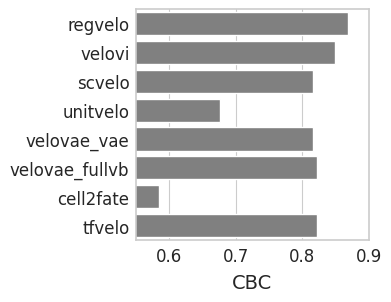

In [7]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3), sharey=True)
    # Plot the second Seaborn plot on the first subplot
    sns.barplot(y="method", x="CBC", data=cbc_df, capsize=0.1, color="grey", order=VELO_METHODS, ax=ax)
    ax.set_xlabel("CBC", fontsize=14)
    ax.set_ylabel("")
    plt.xlim(0.55, 0.9)
    plt.show()

### Latent time

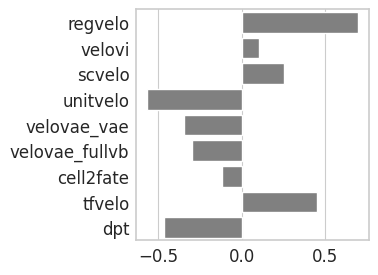

In [8]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3), sharey=True)
    # Plot the second Seaborn plot on the first subplot
    sns.barplot(y="method", x="spearman_corr", data=time_df, capsize=0.1, color="grey", order=TIME_METHODS, ax=ax)
    ax.set_xlabel("", fontsize=14)
    ax.set_ylabel("")
    plt.show()

## Confidence

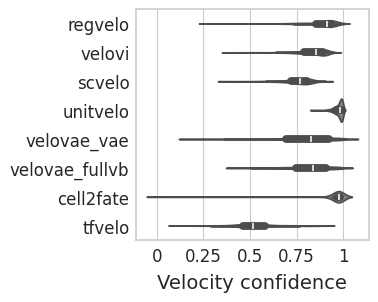

In [9]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3), sharey=True)
    sns.violinplot(
        data=confi_df,
        ax=ax,
        orient="h",
        y="method",
        x="confidence",
        color="grey",
        order=VELO_METHODS,
    )
    # plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel("Velocity confidence", fontsize=14)
    ax.set_ylabel("")
    plt.show()

### GRN

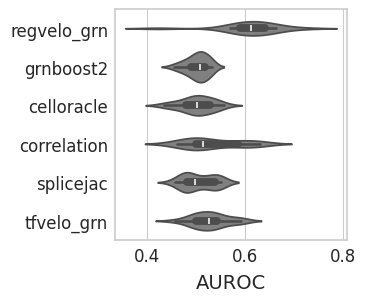

In [10]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3), sharey=True)
    sns.violinplot(
        data=grn_df,
        ax=ax,
        orient="h",
        y="method",
        x="AUROC",
        color="grey",
        order=GRN_METHODS,
    )
    # plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_xlabel("AUROC", fontsize=14)
    ax.set_ylabel("")
    plt.show()